In [1]:
rainfall = spark.read.table("SG_Weather_Lakehouse.dbo.rainfall_bronze").distinct()
rainfall.show(5)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 3, Finished, Available, Finished)

+--------+--------+--------+---------+-------------------+--------+
|deviceId|location|latitude|longitude|           dateTime|rainfall|
+--------+--------+--------+---------+-------------------+--------+
|    S211|    S211| 1.42918|103.75711|2023-01-30 12:55:00|     0.0|
|    S211|    S211| 1.42918|103.75711|2023-01-30 13:30:00|     0.0|
|    S213|    S213| 1.32427| 103.8097|2023-01-30 06:45:00|     0.0|
|    S213|    S213| 1.32427| 103.8097|2023-01-30 07:05:00|     0.0|
|    S214|    S214| 1.29911|103.88289|2023-01-30 04:55:00|     0.0|
+--------+--------+--------+---------+-------------------+--------+
only showing top 5 rows



In [2]:
from pyspark.sql.functions import col, when, count, desc
from pyspark.sql.functions import year, month, to_date, dayofmonth, hour, minute
from pyspark.sql import functions as F

# Extracting year, month, and day columns
rainfall = rainfall.withColumn('date',to_date("dateTime")) \
           .withColumn("year", year("dateTime")) \
           .withColumn("month", F.date_format(F.col("date"), 'MMM')) \
           .withColumn('month_numeric',month("dateTime")) \
           .withColumn("day", dayofmonth("dateTime")) \
           .withColumn("hour", hour("dateTime")) \
           .withColumn("minute", minute("dateTime"))

# Cache DataFrame in memory
rainfall = rainfall.cache()

rainfall.show(5)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 4, Finished, Available, Finished)

+--------+-----------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|deviceId|   location|latitude|longitude|           dateTime|rainfall|      date|year|month|month_numeric|day|hour|minute|
+--------+-----------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|    S106| Pulau Ubin|  1.4168| 103.9673|2025-01-11 07:30:00|     0.6|2025-01-11|2025|  Jan|            1| 11|   7|    30|
|    S106| Pulau Ubin|  1.4168| 103.9673|2025-01-11 16:45:00|     0.2|2025-01-11|2025|  Jan|            1| 11|  16|    45|
|    S106| Pulau Ubin|  1.4168| 103.9673|2025-01-11 17:50:00|     0.0|2025-01-11|2025|  Jan|            1| 11|  17|    50|
|    S106| Pulau Ubin|  1.4168| 103.9673|2025-01-11 19:05:00|     0.0|2025-01-11|2025|  Jan|            1| 11|  19|     5|
|    S111|Scotts Road| 1.31055| 103.8365|2025-01-11 11:10:00|     0.2|2025-01-11|2025|  Jan|            1| 11|  11|    10|
+--------+------

In [3]:
grouped_rainfall = rainfall.groupBy("deviceId","year","month","day") \
                   .agg(count("*").alias("row_count")) \
                   .orderBy("deviceId","year","month","day") 
grouped_rainfall.show(5)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 5, Finished, Available, Finished)

+--------+----+-----+---+---------+
|deviceId|year|month|day|row_count|
+--------+----+-----+---+---------+
|     S06|2024|  Dec|  1|      287|
|     S06|2024|  Dec|  2|      287|
|     S06|2024|  Dec|  3|      287|
|     S06|2024|  Dec|  4|      287|
|     S06|2024|  Dec|  5|      287|
+--------+----+-----+---+---------+
only showing top 5 rows



StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 6, Finished, Available, Finished)

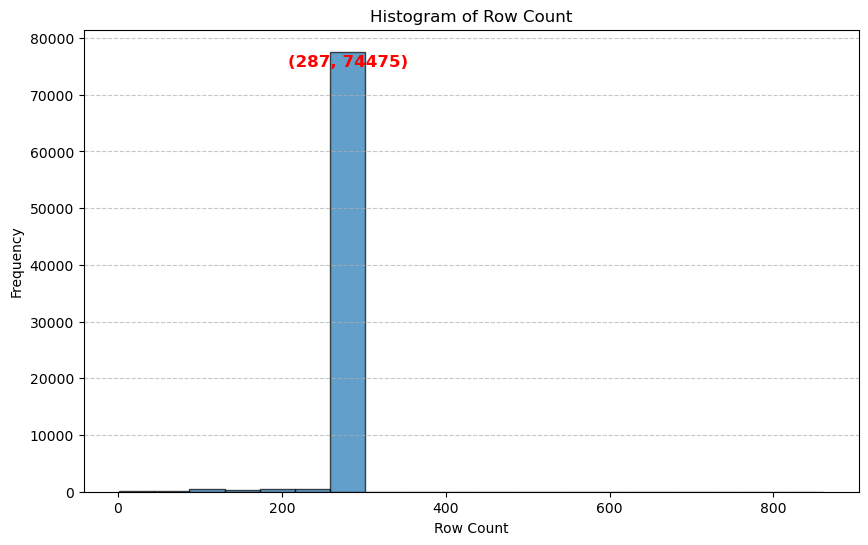

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to Pandas DataFrame
pandas_df = grouped_rainfall.toPandas()

# Compute frequency table
frequency_table = pandas_df["row_count"].value_counts().reset_index()
frequency_table.columns = ["row_count", "frequency"]

# Get the most frequent row_count and its frequency
most_frequent_row_count = frequency_table.iloc[0]["row_count"]
highest_frequency = frequency_table.iloc[0]["frequency"]

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(pandas_df["row_count"], bins=20, edgecolor="black", alpha=0.7)

# Find the bin corresponding to the most frequent row_count
closest_bin_index = np.digitize(most_frequent_row_count, bins) - 1
bin_center = (bins[closest_bin_index] + bins[closest_bin_index + 1]) / 2  # Compute the center of the bin

# Annotate the most frequent row_count with its frequency
plt.text(bin_center, highest_frequency, f"({most_frequent_row_count}, {highest_frequency})", 
         ha="center", va="bottom", fontsize=12, fontweight="bold", color="red")

# Labels and grid
plt.xlabel("Row Count")
plt.ylabel("Frequency")
plt.title("Histogram of Row Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

## 287 count is the highest frequency, because (24*60)/5=288, then we need to minus 1, because of
## per day is 5mins interval count, and the last count falls to the next date.

In [5]:
import pandas as pd

# Convert to Pandas DataFrame
pandas_df = grouped_rainfall.toPandas()

# Create frequency table
frequency_table = pandas_df["row_count"].value_counts().reset_index()
frequency_table.columns = ["row_count", "frequency"]
frequency_table = frequency_table.sort_values(by="row_count")

# Display table
print(frequency_table)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 7, Finished, Available, Finished)

     row_count  frequency
38           1         17
63           2          9
128          3          6
123          4          6
84           5          7
..         ...        ...
2          285        240
1          286        726
0          287      74475
35         574         24
284        861          1

[288 rows x 2 columns]


In [6]:
grouped_rainfall_complete = grouped_rainfall.filter("row_count == 287")
grouped_rainfall_incomplete = grouped_rainfall.filter("row_count != 287")
quality = grouped_rainfall_complete.count()/(grouped_rainfall_complete.count()+grouped_rainfall_incomplete.count())*100
quality 

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 8, Finished, Available, Finished)

93.33759446554123

In [7]:
rainfall_filtered = rainfall.filter("location == 'Somerset Road' AND year == 2025 AND \
                                     month == 'Jul' AND day == 25")
rainfall_filtered.count()

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 9, Finished, Available, Finished)

287

In [8]:
rainfall.filter((rainfall.deviceId == 'S201') & \
                (rainfall.date == '2023-02-28')).sort(desc("dateTime")).show(5)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 10, Finished, Available, Finished)

+--------+--------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|deviceId|location|latitude|longitude|           dateTime|rainfall|      date|year|month|month_numeric|day|hour|minute|
+--------+--------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|    S201|    S201| 1.32311|103.76714|2023-02-28 23:55:00|   3.618|2023-02-28|2023|  Feb|            2| 28|  23|    55|
|    S201|    S201| 1.32311|103.76714|2023-02-28 23:50:00|   2.613|2023-02-28|2023|  Feb|            2| 28|  23|    50|
|    S201|    S201| 1.32311|103.76714|2023-02-28 23:45:00|    4.02|2023-02-28|2023|  Feb|            2| 28|  23|    45|
|    S201|    S201| 1.32311|103.76714|2023-02-28 23:40:00|   3.618|2023-02-28|2023|  Feb|            2| 28|  23|    40|
|    S201|    S201| 1.32311|103.76714|2023-02-28 23:35:00|   0.603|2023-02-28|2023|  Feb|            2| 28|  23|    35|
+--------+--------+--------+---------+--

In [9]:
rainfall.printSchema()

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 11, Finished, Available, Finished)

root
 |-- deviceId: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- dateTime: timestamp (nullable = true)
 |-- rainfall: double (nullable = true)
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- month_numeric: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [10]:
rainfall.write.format("delta").partitionBy("year","month").mode("overwrite").\
         saveAsTable('rainfall_silver')

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 12, Finished, Available, Finished)

In [11]:
rainfall.createOrReplaceTempView("ParquetRainfallTable")
spark.sql("select * from ParquetRainfallTable where rainfall >= 10 order by rainfall desc").show()

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 13, Finished, Available, Finished)

+--------+--------------------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|deviceId|            location|latitude|longitude|           dateTime|rainfall|      date|year|month|month_numeric|day|hour|minute|
+--------+--------------------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|    S107|  East Coast Parkway|  1.3135| 103.9625|2022-08-21 20:20:00|    37.2|2022-08-21|2022|  Aug|            8| 21|  20|    20|
|    S107|  East Coast Parkway|  1.3135| 103.9625|2022-08-20 07:25:00|    29.4|2022-08-20|2022|  Aug|            8| 20|   7|    25|
|    S107|  East Coast Parkway|  1.3135| 103.9625|2022-08-20 13:35:00|    24.2|2022-08-20|2022|  Aug|            8| 20|  13|    35|
|    S107|  East Coast Parkway|  1.3135| 103.9625|2022-08-21 20:10:00|    21.8|2022-08-21|2022|  Aug|            8| 21|  20|    10|
|     S35|   Old Toh Tuck Road|  1.3329| 103.7556|2022-02-06 16:40:00|    21

In [12]:
%%sql
SELECT date, round(sum(rainfall),2) as DailyRainfall FROM ParquetRainfallTable WHERE location == "Clementi Road" GROUP BY date  ORDER BY date

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 14, Finished, Available, Finished)

<Spark SQL result set with 1000 rows and 2 fields>

In [13]:
spark.sql("SELECT * FROM ParquetRainfallTable WHERE month == 'Apr' AND  \
          location = 'Clementi Road' ORDER BY rainfall desc").show(5)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 15, Finished, Available, Finished)

+--------+-------------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|deviceId|     location|latitude|longitude|           dateTime|rainfall|      date|year|month|month_numeric|day|hour|minute|
+--------+-------------+--------+---------+-------------------+--------+----------+----+-----+-------------+---+----+------+
|     S50|Clementi Road|  1.3337| 103.7768|2025-04-20 17:00:00|    10.8|2025-04-20|2025|  Apr|            4| 20|  17|     0|
|     S50|Clementi Road|  1.3337| 103.7768|2022-04-23 14:45:00|    10.8|2022-04-23|2022|  Apr|            4| 23|  14|    45|
|     S50|Clementi Road|  1.3337| 103.7768|2025-04-20 17:05:00|    10.8|2025-04-20|2025|  Apr|            4| 20|  17|     5|
|     S50|Clementi Road|  1.3337| 103.7768|2025-04-13 14:10:00|    10.4|2025-04-13|2025|  Apr|            4| 13|  14|    10|
|     S50|Clementi Road|  1.3337| 103.7768|2022-04-11 11:05:00|    10.0|2022-04-11|2022|  Apr|            4| 11|  11|     5|


In [14]:
DailyRainfall = """
   SELECT date, round(sum(rainfall),2) as DailyRainfall
   FROM ParquetRainfallTable 
   WHERE location == 'Clementi Road' AND date >= '2025-01-01' AND date <= '2025-01-20'
   GROUP BY date
   ORDER BY date
"""
spark.sql(DailyRainfall).show()

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 16, Finished, Available, Finished)

+----------+-------------+
|      date|DailyRainfall|
+----------+-------------+
|2025-01-01|          0.4|
|2025-01-02|          2.4|
|2025-01-03|         10.2|
|2025-01-04|          0.2|
|2025-01-05|          2.8|
|2025-01-06|          0.0|
|2025-01-07|          0.0|
|2025-01-08|          0.0|
|2025-01-09|          0.0|
|2025-01-10|        105.0|
|2025-01-11|        88.74|
|2025-01-12|         41.2|
|2025-01-13|        72.84|
|2025-01-15|          7.2|
|2025-01-16|          2.2|
|2025-01-17|          1.8|
|2025-01-18|          3.2|
|2025-01-19|         23.0|
+----------+-------------+



StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 17, Finished, Available, Finished)

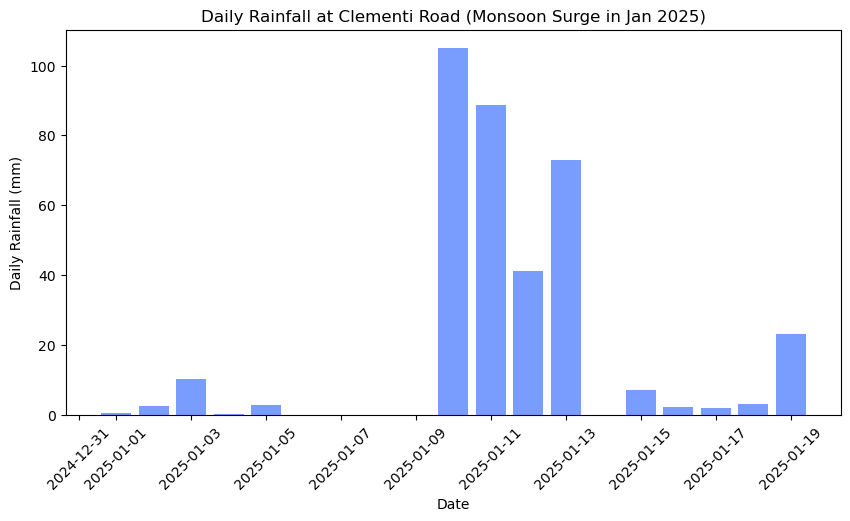

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas
DailyRainfall = spark.sql(DailyRainfall).toPandas()

# Plot bar chart
plt.figure(figsize=(10,5))
plt.bar(DailyRainfall['date'], DailyRainfall['DailyRainfall'], color='#799CFF')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Daily Rainfall (mm)")
plt.title("Daily Rainfall at Clementi Road (Monsoon Surge in Jan 2025)")
plt.xticks(rotation=45)

# Show plot
plt.show()

In [16]:
MonthlyRainfall_2022 = """
SELECT month, round(SUM (rainfall),2) as MonthlyRainfall
   FROM ParquetRainfallTable 
   WHERE location == "Clementi Road" AND year == 2022
   GROUP BY month, month_numeric
   ORDER BY month_numeric
"""
spark.sql(MonthlyRainfall_2022).show()

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 18, Finished, Available, Finished)

+-----+---------------+
|month|MonthlyRainfall|
+-----+---------------+
|  Jan|          132.8|
|  Feb|          218.8|
|  Mar|          222.6|
|  Apr|          251.8|
|  May|          222.2|
|  Jun|          224.4|
|  Jul|          106.8|
|  Aug|          330.0|
|  Sep|          330.4|
|  Oct|          457.4|
|  Nov|          282.2|
|  Dec|          230.2|
+-----+---------------+



StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 19, Finished, Available, Finished)

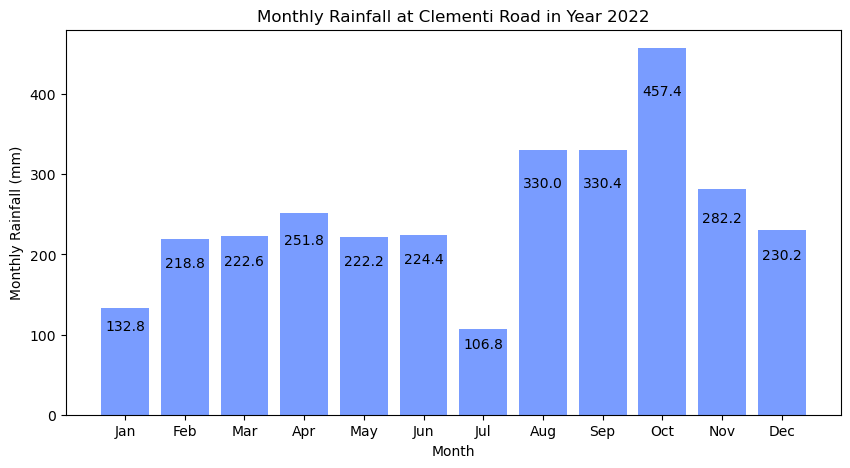

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas
MonthlyRainfall = spark.sql(MonthlyRainfall_2022).toPandas()

# Plot bar chart with light blue color
plt.figure(figsize=(10, 5))
bars = plt.bar(MonthlyRainfall['month'], MonthlyRainfall['MonthlyRainfall'], color='#799CFF')  # Light blue

# Labels and title
plt.xlabel("Month")
plt.ylabel("Monthly Rainfall (mm)")
plt.title("Monthly Rainfall at Clementi Road in Year 2022")
plt.xticks(rotation=0)

# Annotate each bar with the rainfall value inside the bars
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (rainfall value)
    plt.text(bar.get_x() + bar.get_width()/2, yval - (yval * 0.1),  # Slightly lower inside the bar
             f"{yval:.1f}", ha='center', va='top', fontsize=10, color='black')

# Show plot
plt.show()

In [18]:
MonthlyRainfall_byYear = """
SELECT year, month, round(SUM (rainfall),2) as MonthlyRainfall
   FROM ParquetRainfallTable 
   WHERE location == "Clementi Road" 
   GROUP BY year, month, month_numeric
   ORDER BY year, month_numeric
"""
spark.sql(MonthlyRainfall_byYear).show(50)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 20, Finished, Available, Finished)

+----+-----+---------------+
|year|month|MonthlyRainfall|
+----+-----+---------------+
|2022|  Jan|          132.8|
|2022|  Feb|          218.8|
|2022|  Mar|          222.6|
|2022|  Apr|          251.8|
|2022|  May|          222.2|
|2022|  Jun|          224.4|
|2022|  Jul|          106.8|
|2022|  Aug|          330.0|
|2022|  Sep|          330.4|
|2022|  Oct|          457.4|
|2022|  Nov|          282.2|
|2022|  Dec|          230.2|
|2023|  Jan|          140.0|
|2023|  Feb|          360.2|
|2023|  Mar|          342.8|
|2023|  Apr|          230.0|
|2023|  May|          143.0|
|2023|  Jun|          279.0|
|2023|  Jul|          324.8|
|2023|  Aug|          119.4|
|2023|  Sep|          151.8|
|2023|  Oct|          176.6|
|2023|  Nov|          306.6|
|2023|  Dec|          374.0|
|2024|  Jan|          313.2|
|2024|  Feb|          162.8|
|2024|  Mar|          156.4|
|2024|  Apr|          163.8|
|2024|  May|         230.22|
|2024|  Jun|          319.2|
|2024|  Jul|           79.0|
|2024|  Aug|  

In [19]:
MonthlyRainfall = spark.sql(MonthlyRainfall_byYear).toPandas()
print(MonthlyRainfall.columns)

StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 21, Finished, Available, Finished)

Index(['year', 'month', 'MonthlyRainfall'], dtype='object')


StatementMeta(, 13cdad99-baa6-4366-9502-b1de145db01d, 22, Finished, Available, Finished)

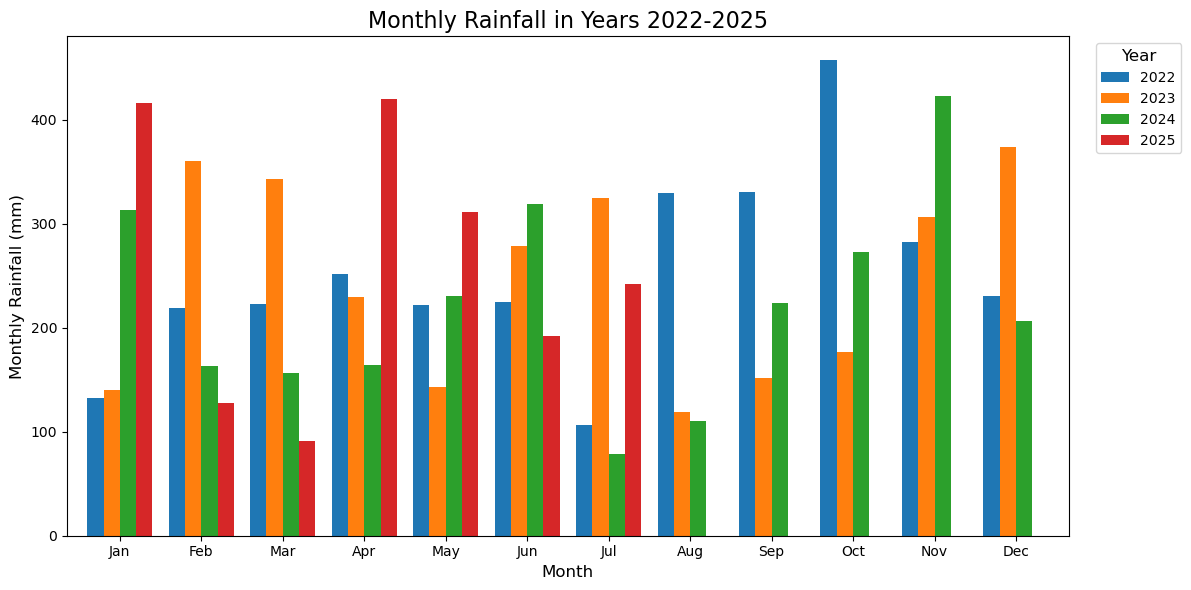

In [20]:
import matplotlib.pyplot as plt

# Define the correct order of months
correct_month_order = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]

# Convert the 'month' column to a categorical type with the specified order
MonthlyRainfall['month'] = pd.Categorical(
    MonthlyRainfall['month'], 
    categories=correct_month_order, 
    ordered=True
)

# Sort the DataFrame by the 'month' column
MonthlyRainfall = MonthlyRainfall.sort_values('month')

# Pivot data for plotting
pivoted_data = MonthlyRainfall.pivot(index='month', columns='year', values='MonthlyRainfall')

# Plotting
pivoted_data.plot(kind='bar', figsize=(12, 6), width=0.8)

# Adding labels and title
plt.title('Monthly Rainfall in Years 2022-2025', fontsize=16)
plt.ylabel('Monthly Rainfall (mm)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

# Adjusting the legend
plt.legend(
    title='Year', 
    fontsize=10, 
    title_fontsize=12, 
    loc='upper left', 
    bbox_to_anchor=(1.02, 1)
)

# Display the plot
plt.tight_layout()
plt.show()